# "아침"시간대 유동인구의 추세(trend) 성분 예측

## 1. import library

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import random
import warnings
import pickle
warnings.filterwarnings(action='ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
torch.manual_seed(1015)
# define 'device' to upload tensor in gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import sklearn
from sklearn.neighbors import KNeighborsRegressor

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 


from utils.preprocess_utils import *
from utils.train_utils import *
from models.model_trend.trend_lstm import LSTMModel_trend

## 2. 데이터 불러오기

In [8]:
### morning data
with open('../data/preprocess/m_data_list.pkl', 'rb') as f:
    data_list = pickle.load(f)
    
data_list = append_cycle_size(data_list)

train_time, train_notime, train_y,\
valid_time, valid_notime, valid_y, \
    test_time, test_notime, test_y = numpy2tensor(data_list)

## 3. 모델 불러오기

In [9]:
# Load model
model_trend = LSTMModel_trend(input_size = 12, hidden_size = 32, no_time_size =4).to(device)
optimizer = torch.optim.Adam(model_trend.parameters(), lr = 1e-2)
criterion = nn.MSELoss(size_average = True)

## 4. 훈련

In [ ]:
# Train model
num_epochs  = 500
hist = np.zeros(num_epochs)

train_error = []
valid_error = []

hist = {'best_val_error': 100,
        'best_val_epoch': 0}


for t in range(num_epochs):
    train_trend_pred = model_trend(train_time, train_notime)
    loss = criterion(train_trend_pred, train_y[:,:,0]) ### trend
    train_error.append(loss)

    valid_trend_pred = model_trend(valid_time, valid_notime)
    valid_mse = float(criterion(valid_trend_pred, valid_y[:,:,0]).cpu()) ### trend
    valid_error.append(valid_mse)
    if hist['best_val_error'] >= valid_mse:
        hist['best_val_error'] = valid_mse
        hist['best_val_epoch'] = t
        torch.save(model_trend, 'models/best_trends.pkl')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
    if t % 10 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")
best_model = torch.load('models/best_trends.pkl')


## 5. 훈련 결과

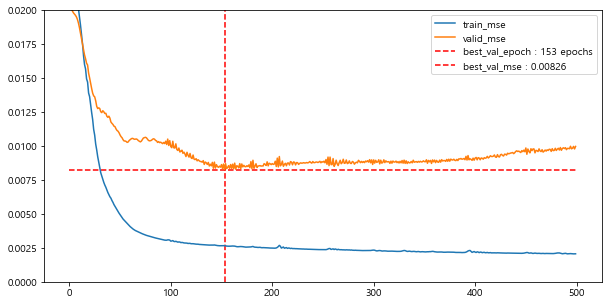

In [11]:
# no time time 곱하기
# cycle size 더하기

plt.figure(figsize = [10, 5])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')

plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 0.1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = num_epochs,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")

plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.02)
plt.show()

In [10]:
best_model = torch.load('models/best_trends.pkl')

In [11]:
# trend
i = 0
print("morning trend")
y = torch.cat((train_y[:,:,i], valid_y[:,:,i], test_y[:,:,i]))
zeros = torch.zeros_like(y).to(device)
print('zeros error : ',np.array((criterion(zeros, y)).cpu()))
rand_normal = torch.randn(y.shape).to(device)
print('random normal error : ',np.array((criterion(rand_normal, y)).cpu()))

morning trend
zeros error :  0.5137806
random normal error :  1.5115879


In [12]:
print("morning trend results")

train_pred = best_model(train_time, train_notime)
print('train_error : ',criterion(train_pred, train_y[:,:,0]))

valid_pred = best_model(valid_time, valid_notime)
print('valid_error : ',criterion(valid_pred, valid_y[:,:,0]))

morning trend results
train_error :  tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward>)
valid_error :  tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward>)


## 6. 훈련 데이터와 검증 데이터의 성능 비교

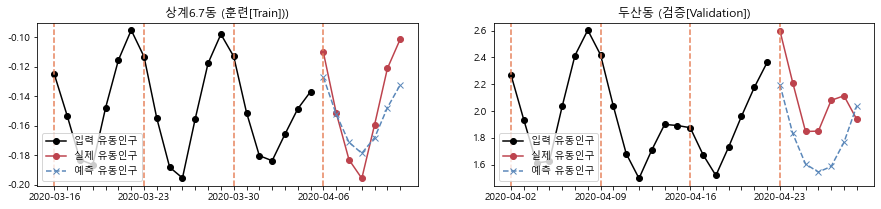

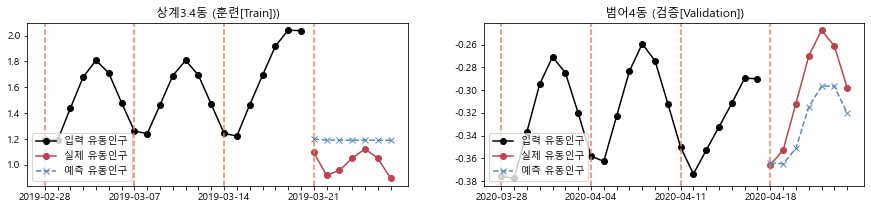

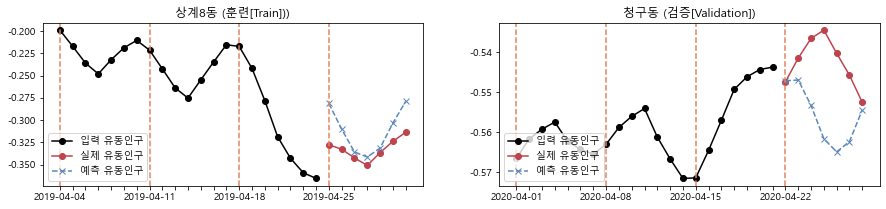

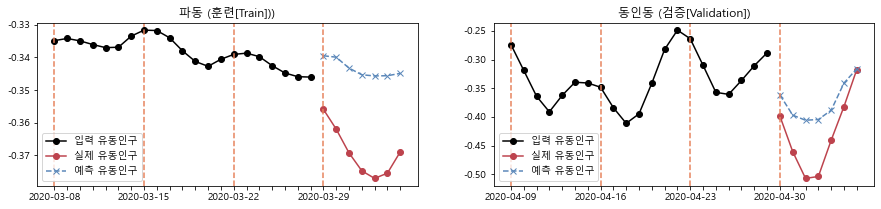

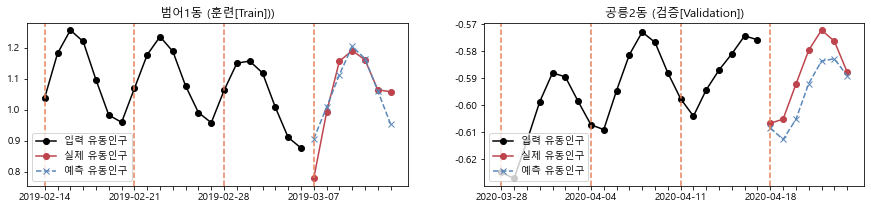

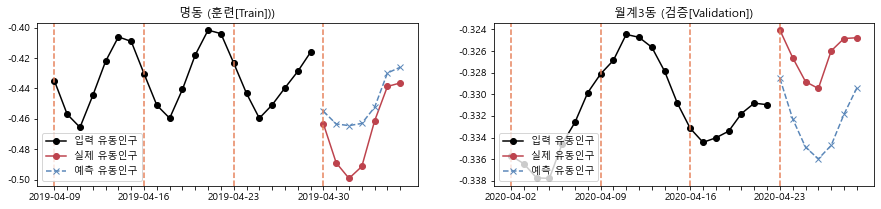

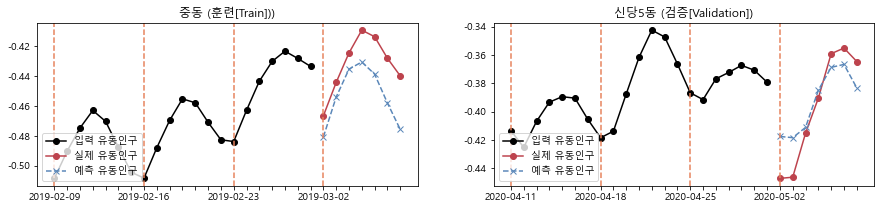

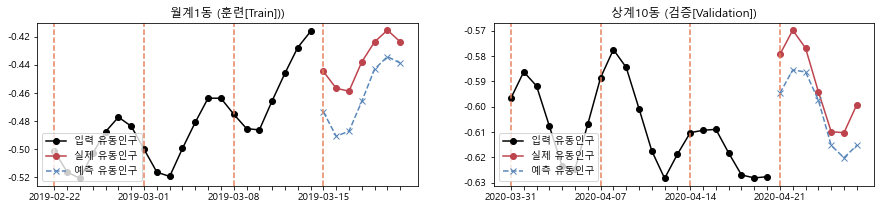

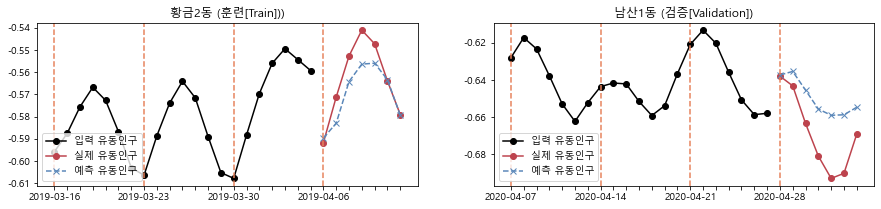

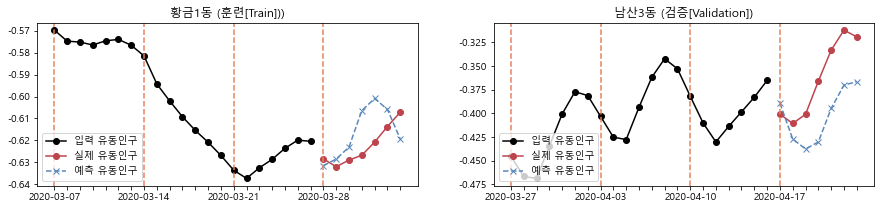

In [13]:
valid_trend_pred = best_model(valid_time, valid_notime)
train_trend_pred = best_model(train_time, train_notime)

train_x_np, train_y_np, train_pred_np,\
valid_time_x_np, valid_y_np, valid_pred_np= tensor2numpy([train_time[:,:,-2], train_y[:,:,0], train_trend_pred,
                                                        valid_time[:,:,-2], valid_y[:,:,0], valid_trend_pred])

plot_predict(train_x_np, train_y_np, train_pred_np,\
                valid_time_x_np, valid_y_np, valid_pred_np)

trend_result_list = [train_x_np, train_y_np, train_pred_np,\
    valid_time_x_np, valid_y_np, valid_pred_np]

### morning result
path = '../data/train_results/morning_results/'
with open(path + 'm_trend_results_list.pkl', 'wb') as f:
    pickle.dump(trend_result_list, f)

## 7. 평가(test set)

In [14]:
test_pred = best_model(test_time, test_notime)
print('test_error : ',criterion(test_pred, test_y[:,:,0]))

test_error :  tensor(0.0621, device='cuda:0', grad_fn=<MseLossBackward>)


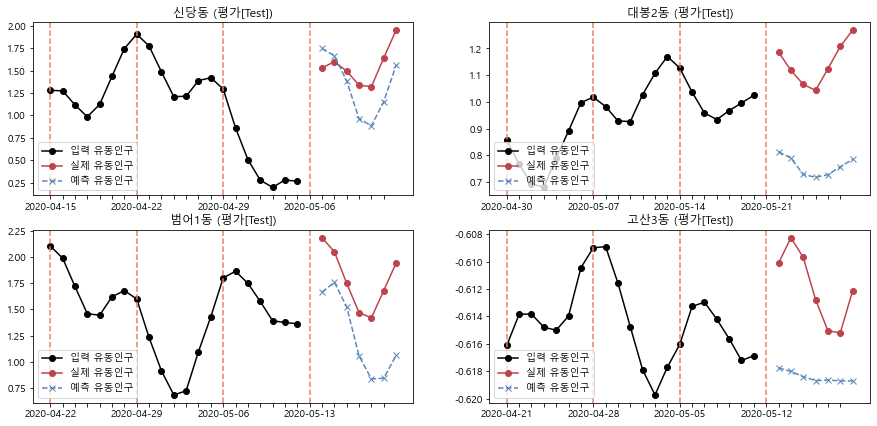

In [15]:
test_pred = best_model(test_time, test_notime)
# convert result
test_time_x_np, test_y_np, test_pred_np = tensor2numpy([test_time[:,:,-2], test_y[:,:,0], test_pred])
# plot result
plot_test_predict(test_time_x_np, test_y_np, test_pred_np)

# save result
trend_result_list = [test_time_x_np, test_y_np, test_pred_np]
path = '../data/train_results/morning_results/'
with open(path + 'm_trend_results_test.pkl', 'wb') as f:
    pickle.dump(trend_result_list, f)

## 8. 6월 유동인구 추세(Trend) 성분 예측

In [16]:
with open('../data/preprocess/june_data/morning_june_time.pkl', 'rb') as f:
    train_time = pickle.load(f)
with open('../data/preprocess/june_data/morning_june_notime.pkl', 'rb') as f:
    train_notime = pickle.load(f)

tc = 0
cycle_size =train_time[:,:,-2].max(axis = 1) - train_time[:,:, -2].min(axis = 1)
train_notime = np.concatenate([train_notime, cycle_size.reshape(-1,1)], axis = 1)

train_time_x, train_notime_x = numpy2tensor([train_time[:,:,3:].astype(np.float64), train_notime.astype(np.float64)])
pred_y = best_model(train_time_x, train_notime_x)
pred_y = np.array(pred_y.cpu().detach())

path = '../data/predict_june/predict_cycle_trend/'
with open(path + 'june_morning_trend_pred.pkl', 'wb') as f:
    pickle.dump(pred_y, f)